In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [2]:
import numpy as np
import itertools
from scipy.stats import norm
import time
import cossio
import kinetics

In [3]:
def pmf2d(xq, qk):
    fig, ax = plt.subplots(figsize=(6,5))
    counts, ybins, xbins, image = ax.hist2d(xk, qk, \
            bins=[np.linspace(-12,12,100), np.linspace(-12,12,100)])
    pmf = -np.log(counts.transpose())
    pmf -= np.min(pmf)
    cs = ax.contourf(pmf, \
            extent=[xbins.min(), xbins.max(), ybins.min(), ybins.max()], \
            cmap=cm.rainbow, levels=np.arange(0,10 ,1))
    cbar = plt.colorbar(cs)
    ax.set_xlim(-12,12)
    ax.set_ylim(-12,12)
    ax.set_xlabel('$x$', fontsize=20)
    ax.set_ylabel('$q$', fontsize=20)
    plt.tight_layout()

In [4]:
def calc_rates(y):
    lifeA, lifeB = kinetics.calc_life([y])
    meanA = 1./np.exp(np.mean(np.log([x for x in lifeA if x>0])))
    meanB = 1./np.exp(np.mean(np.log([x for x in lifeB if x>0])))
    errorA = meanA/np.sqrt(len(lifeA))
    errorB = meanA/np.sqrt(len(lifeB))
    return np.mean([meanA, meanB]), np.mean([errorA, errorB])

In [27]:
# Globals
dt = 5e-3
Dx = 1. # Diffusion coefficient for molecular coordinate

### Molecular potential of mean force 

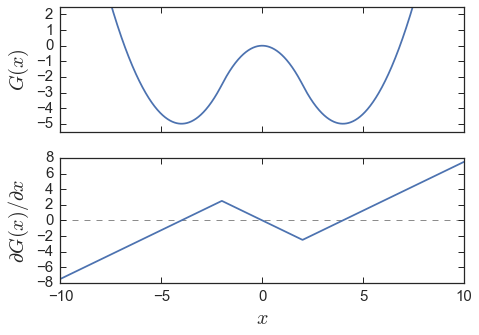

In [59]:
x = np.linspace(-10,10,1000)
fig, ax = plt.subplots(2,1, figsize=(7,5), sharex=True)
Gx = [cossio.Gx(y, barrier=5.) for y in x]
dGqxdx = [cossio.dGqxdx(0, y, barrier=5.) for y in x]
ax[0].plot(x, Gx)
ax[0].set_ylabel('$G(x)$', fontsize=20)
ax[0].set_ylim(-1.1*5,0.5*5)

ax[1].plot(x, dGqxdx)
ax[1].set_xlabel('$x$', fontsize=20)
ax[1].set_ylabel('$\partial G(x)/\partial x$', fontsize=20)
ax[1].hlines(0, -10, 10, linestyle='dashed', linewidth=0.5)

#ax[2].set_ylabel('$\partial^2 G(x)/\partial x^2$', fontsize=20)

plt.tight_layout()

### Diffusion on molecular coordinate

In [42]:
start = time.time()
x, q = [5., 0.]
xk, qk = cossio.run_brownian(x0=x, dt=dt, barrier=5., kl=0., \
                             Dx=Dx, numsteps=int(2e7), fwrite=100)
end = time.time()
print end - start

41.9757370949


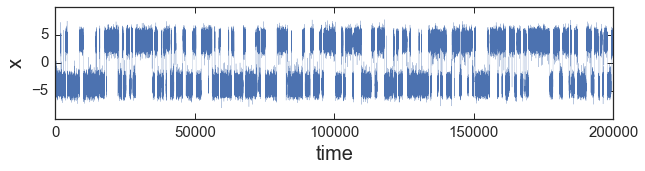

In [43]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(xk, linewidth=0.2)
ax.set_ylim(-10,10)
ax.set_yticks([-5.,0,5.])
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('x', fontsize=20)

In [44]:
rate0 = np.array(calc_rates(xk))
print rate0

[ 0.00136078  0.00014489]


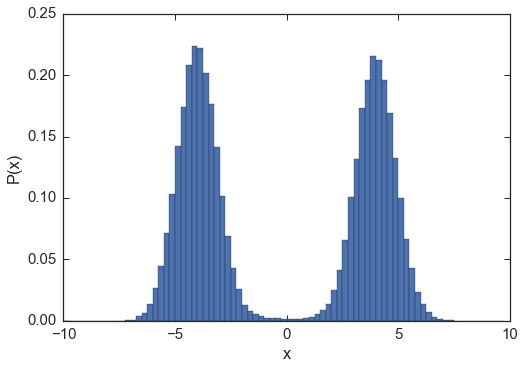

In [45]:
fig, ax = plt.subplots()
hist, bin_edges, patches = \
        ax.hist(xk, bins=np.arange(-10,10,0.25), normed=True)
ax.set_ylabel('P(x)')
ax.set_xlabel('x')

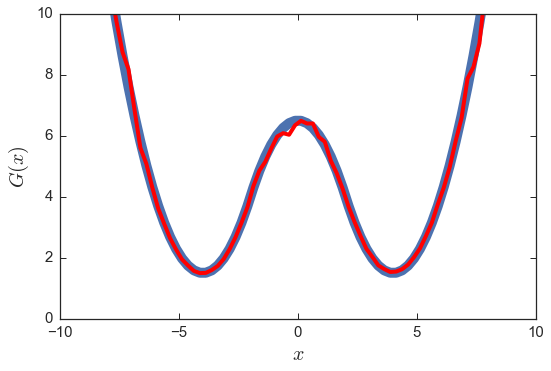

In [46]:
bin_centers = [0.5*(bin_edges[i]+bin_edges[i+1]) \
               for i in range(len(bin_edges)-1)]
fig, ax = plt.subplots()
ax.plot(bin_centers, [cossio.Gx(x) + 6.5   for x in bin_centers], lw=10)
ax.plot(bin_centers, -np.log(hist), 'red', lw=4)
ax.set_ylabel('$G(x)$', fontsize=20)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylim(0,10)
plt.tight_layout()

### Diffusion on measuring coordinate

In [51]:
kl = 0.3
x, q = [5., 5.]
xk, qk = cossio.run_brownian(x0=x, dt=dt, barrier=5., kl=kl, \
                             Dx=0, Dq=Dx, numsteps=int(1e6), fwrite=100)

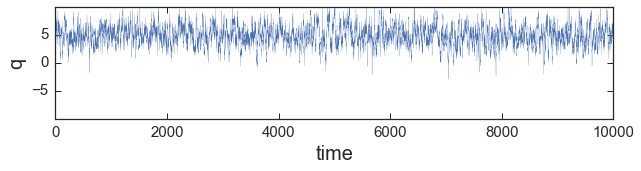

In [55]:
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(qk, linewidth=0.2)
#ax.plot(qk[0:-1:100], linewidth=0.1)
ax.set_ylim(-10,10)
ax.set_yticks([-5.,0,5.])
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('q', fontsize=20)

### Diffusion in two dimensions

In [56]:
x = np.linspace(-10,10,100)
G2d = np.ones((50, 100), float)*[cossio.Gx(y, barrier=5.) for y in x]
q = np.linspace(-12,12,50)
for i, j in itertools.product(range(50), range(100)):
    G2d[i,j] += cossio.V(q[i], x[j], kl)
G2d = np.array(G2d)
G2d -= np.min(G2d)

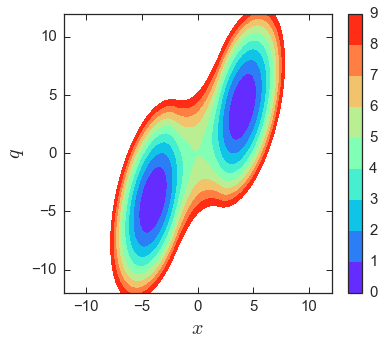

In [57]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(6,5))
cs = ax.contourf(x, q,  G2d, cmap=cm.rainbow, levels=np.arange(0,10,1))
cbar = plt.colorbar(cs)
ax.set_xlim(-12,12)
ax.set_ylim(-12,12)
ax.set_xlabel('$x$', fontsize=20)
ax.set_ylabel('$q$', fontsize=20)

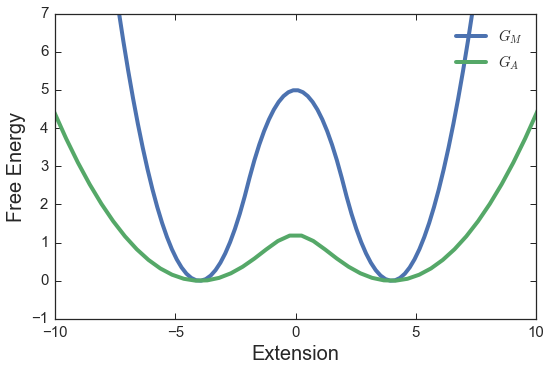

In [58]:
expGM = np.trapz(np.exp(-G2d), q, axis=0)
GM = -np.log(expGM)
expGA = np.trapz(np.exp(-G2d), x, axis=1)
GA = -np.log(expGA)
fig, ax = plt.subplots()
ax.plot(x, GM - np.min(GM), label='$G_M$', lw=4)
ax.plot(q, GA  - np.min(GA), label='$G_A$', lw=4)
#ax.plot(bin_centers, [cossio.Gx(y) for y in bin_centers], '--', c='red', lw=3)
ax.set_xlim(-10,10)
ax.set_ylim(-1,7)
ax.set_xlabel('Extension', fontsize=20)
ax.set_ylabel('Free Energy', fontsize=20)
ax.legend(loc=1)
fig.tight_layout()

In [60]:
x, q = [5., 5.]
xk, qk = cossio.run_brownian(x0=x, dt=dt, barrier=5., kl=kl, \
                             Dx=Dx, Dq=Dx, numsteps=int(2e7), fwrite=100)

(-10, 10)

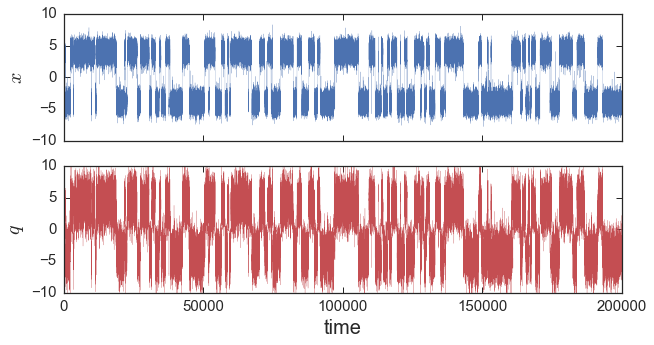

In [61]:
fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, sharey=True)
ax[0].plot(xk, linewidth=0.2)
ax[1].plot(qk, 'r', linewidth=0.2)
ax[1].set_xlabel('time', fontsize=20)
ax[1].set_ylabel('$q$', fontsize=20)
ax[0].set_ylabel('$x$', fontsize=20)
ax[0].set_ylim(-10, 10)
#ax[0].set_xlim(0, numsteps)

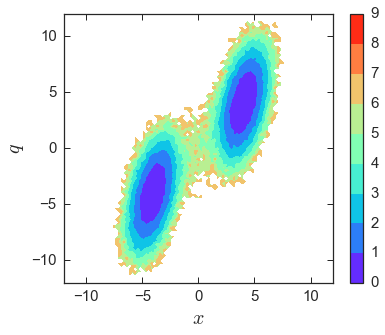

In [62]:
pmf2d(xk,qk)

In [63]:
print np.array(calc_rates(xk))

[ 0.00099347  0.00014779]


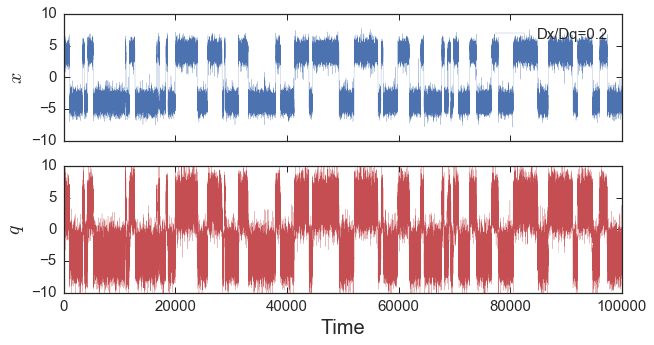

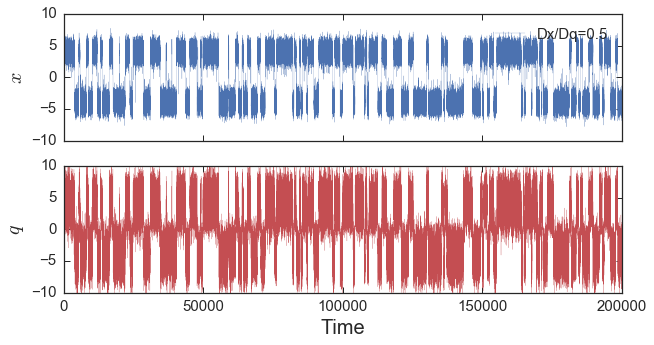

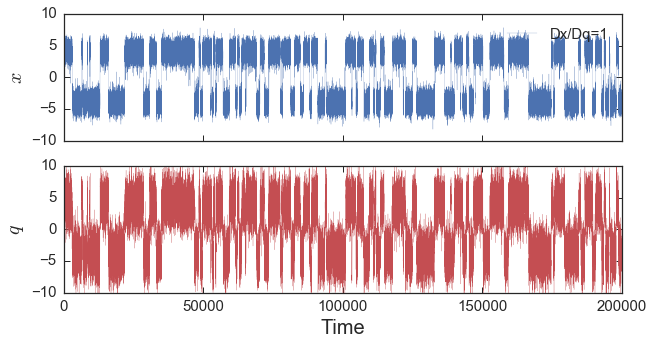

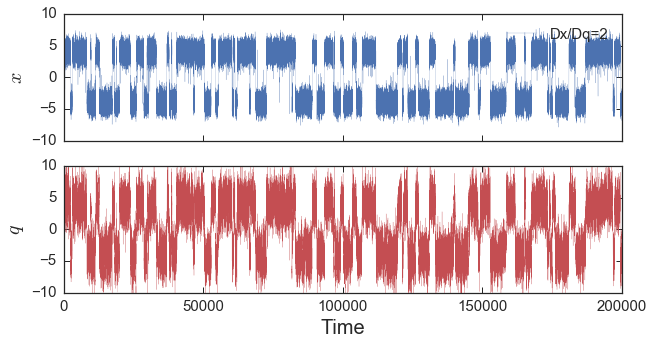

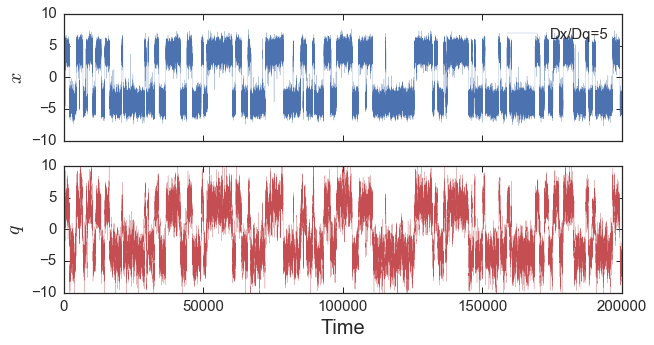

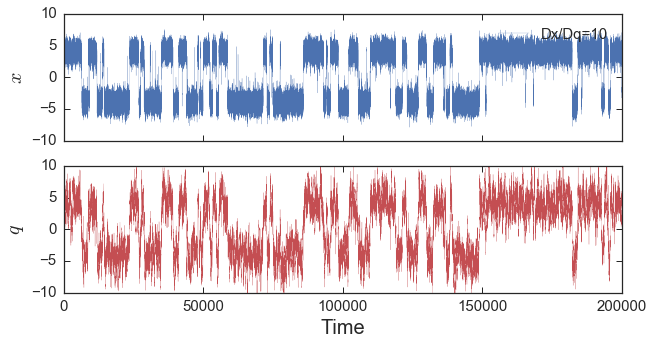

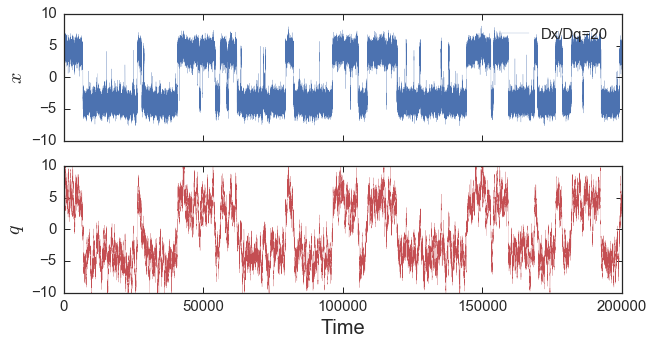

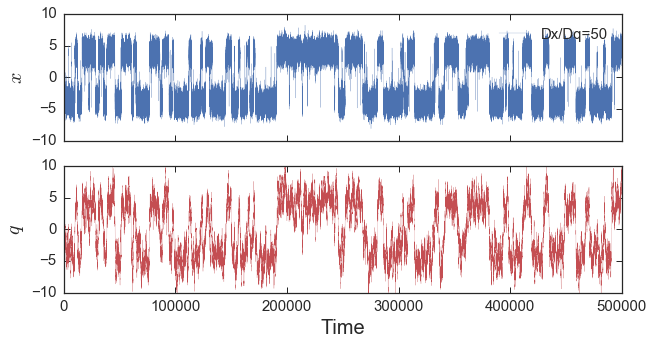

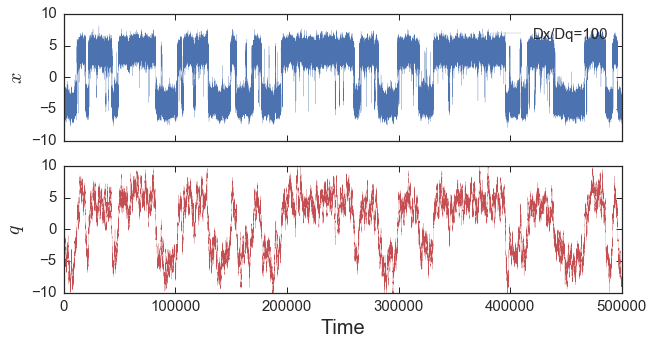

In [67]:
scaling = [5, 2, 1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01]
nsteps = [1e7, 2e7, 2e7, 2e7, 2e7, 2e7, 2e7, 5e7, 5e7, 5e7]
trajs = {}
for i,sc in enumerate(scaling):
    trajs[sc] = {}
    x, q = [5., 5.]
    numsteps = int(nsteps[i])
    xk, qk = cossio.run_brownian(x0=x, dt=dt, barrier=5., kl=kl, \
                             Dx=Dx, Dq=Dx*sc, numsteps=numsteps, fwrite=100)
    trajs[sc]['x'] = xk
    trajs[sc]['q'] = qk
    
    fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=True, sharey=True)
    ax[0].plot(xk, linewidth=0.2, label='Dx/Dq=%g'%(1./sc))
    ax[1].plot(qk, 'r', linewidth=0.2)
    ax[1].set_xlabel('Time', fontsize=20)
    ax[1].set_ylabel('$q$', fontsize=20)
    ax[0].set_ylabel('$x$', fontsize=20)
    ax[0].set_ylim(-10, 10)
    ax[0].legend(loc=1)

In [69]:
kfq = []
kfx = []
for i, sc in enumerate(scaling):
    kfx.append(calc_rates(trajs[sc]['x']))
    kfq.append(calc_rates(trajs[sc]['q']))

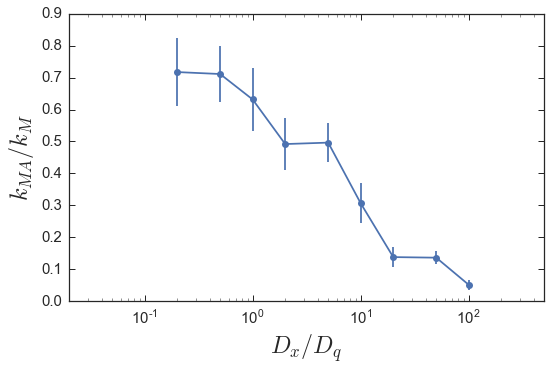

In [72]:
fig, ax = plt.subplots()
rates = np.array(kfq)
ax.errorbar(1./np.array(scaling), rates[:,0]/rate0[0], \
            rates[:,1]/rate0[0], marker='o')
ax.set_xscale('log')
ax.set_xlabel('$D_x/D_q$', fontsize=24)
ax.set_ylabel('$k_{MA}/k_M$', fontsize=24)
ax.set_xlim(2e-2,5e2)
plt.tight_layout()